In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from datetime import datetime
import math

#this will mute errors that made your final pdf less legible
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MOVIES/AllClean2.csv')


In [ ]:
pd.set_option('display.max_columns', None)
print(df)

          id                                   title       budget     revenue  \
0      10060                  Get Rich or Die Tryin'   40000000.0  46442528.0   
1      70586                                   Setup   20000000.0   2128186.0   
2       9358                     Final Destination 2   26000000.0  90941129.0   
3     512096                                    Cake     350000.0    850000.0   
4     512096                                    Cake     350000.0    850000.0   
...      ...                                     ...          ...         ...   
9484  538278                               Manticore    6000000.0   1756511.0   
9485  960175                    Karmafal Daata Shani  100000000.0  10000000.0   
9486  426107                                   Alive     110600.0     52400.0   
9487  859016  Super headphones | אוזניות תלת מימדיות     150000.0    178000.0   
9488  948872                                    翠岗红旗     100000.0    100000.0   

      runtime  Drama  Comed

In [ ]:
unUsedColumns=['id','title','year','month','day','revenue_to_budget_ratio','revenue']
xDF = df.drop(columns=unUsedColumns)
print(xDF.head())


       budget  runtime  Drama  Comedy  Action  Thriller  Romance  Adventure  \
0  40000000.0    117.0      1       0       0         0        0          0   
1  20000000.0     85.0      1       0       1         0        0          0   
2  26000000.0     90.0      0       0       0         0        0          0   
3    350000.0    125.0      1       0       0         0        1          0   
4    350000.0    125.0      1       0       0         0        1          0   

   Crime  Horror  Science Fiction  Family  Fantasy  Mystery  Animation  \
0      1       0                0       0        0        0          0   
1      1       0                0       0        0        0          0   
2      0       1                0       0        0        1          0   
3      0       0                0       0        0        1          0   
4      0       0                0       0        0        1          0   

   History  Music  War  Documentary  Western  TV Movie  \
0        0      1    0

Above I am dropping all of the non-numeric variables that will not be used in the model, and am checking the Dataframe to ensure I have what I need

In [ ]:
X = xDF
y = df['revenue']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Setting up my training and testing variables. As you can see we are trying to predict movie revenue based on the variables above. Will be using the same testing and training sets for all different models used below.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
param_grid = {
    'base_estimator__max_depth': [ 1,3, 5, 10] , # Decision Tree max depth
    'n_estimators': [25, 50, 100, 300],  # Number of trees
    'learning_rate': [.001, 0.01, 0.1, 1]  # Learning rate
}
base_estimator = DecisionTreeRegressor()

# Step 4: Instantiate AdaBoost Regressor
ada_boost_regressor = AdaBoostRegressor(base_estimator=base_estimator, random_state=42)

# Step 5: Instantiate GridSearchCV
grid_search = GridSearchCV(ada_boost_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Step 6: Fit the model
grid_search.fit(X_train, y_train)

# Step 7: Best parameter combination
print("Best parameters found:", grid_search.best_params_)

# Step 8: Make predictions with the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Step 9: Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Best parameters found: {'base_estimator__max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 300}
Mean Squared Error: 1.1524958576069528e+16


Above is my Boosted Decision tree model. I used grid search to tune for parameters. I originally only had max_depth as [1,3,5], num_estimators as [25, 50, 100], and learning_rate as [.001, .01, .1], but expanded the inputs because the tuned model used the highest parameters for each of the options.

Best parameters found: {'base_estimator__max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 300}

In [ ]:
##Tuned Model
base_estimator = DecisionTreeRegressor(max_depth=5)

# Initialize the AdaBoost regressor with the base estimator
adaboost_reg = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=300, learning_rate=.01, random_state=42)

# Train the AdaBoost regressor
adaboost_reg.fit(X_train, y_train)

# Make predictions
BoostedPredictions = adaboost_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)



Mean Squared Error: 1.1524958576069528e+16


Above is our tuned boosted decision tree, which happens to be the best model that we were able to get.

In [ ]:
TrainPredictions = adaboost_reg.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_train, TrainPredictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 6632835156664365.0


The Train MSE is .66e+16, compared to 1.15e+16 for the Test MSE, which is a much bigger difference than many of our other models, suggesting this model may be over fitting even though it has the best performance.

In [ ]:
rmse=mse**.5
print(rmse)

107354359.83726756


The Root MSE is 107m, which is still very high considering that most of the Y variables in our dataset under 250m, showing that we don't have very much predictive power with our variables.

In [ ]:
theMean=y_train.mean()

In [ ]:
ones=np.ones(len(y_test))

In [ ]:
ones=ones*theMean

In [ ]:
meanmse=mean_squared_error(y_test,ones)
print(meanmse)

2.5505058063806932e+16


In [ ]:
rmsemean=meanmse**.5
print(rmsemean)

159703030.85354057


Above is the MSE of predicting the mean for the training set onto the Test set, which we are beating by a decent margin now. This shows that our models are somewhat useful, but given the percent error I wouldn't imagine them to be very helpful in a real world setting.

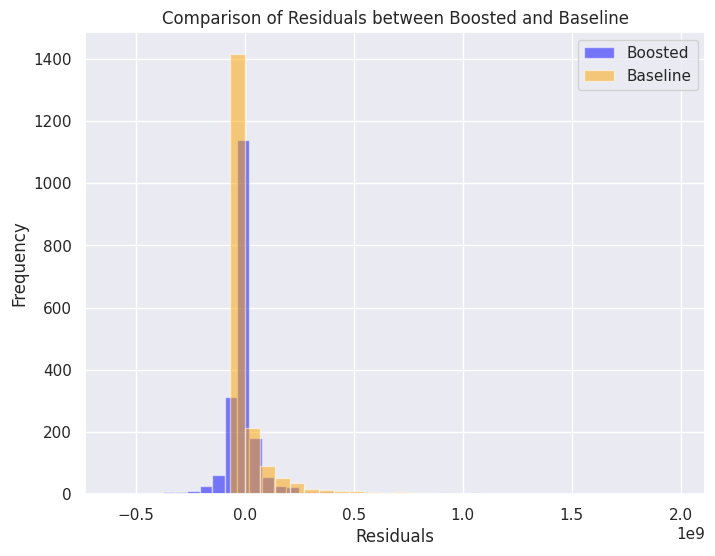

In [ ]:
## Comparing Residuals between the two models
Boostedresiduals = (y_test - BoostedPredictions)
BaselineResiduals = (y_test - ones)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(Boostedresiduals, bins=30, alpha=0.5, color='blue', label='Boosted')

# Plot the residuals of the second model
ax.hist(BaselineResiduals, bins=30, alpha=0.5, color='orange', label='Baseline')

# Add labels and title
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of Residuals between Boosted and Baseline')
ax.legend()

Here is the distributions of the residuals for our boosted model, and when predicting the mean. They both seem to center around zeor which is to be expected, but they still look quite similar to each other. It is also clear that there are major outliers skewing this dataset, as there exist residuals over a billion dollars off. The data having these outliers is liking a big cause of the inability for all of our models to make useful predictions.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define Hyperparameters
param_grid = {'n_neighbors': range(1, 100)}  # Range of k values to test

# Step 6: Cross-Validation
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Step 7: Select Best k
best_k = grid_search.best_params_['n_neighbors']
print("Best number of neighbors:", best_k)

# Step 8: Train Final Model
final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)

# Step 9: Evaluate
KNN_pred = final_knn.predict(X_test_scaled)
mse = mean_squared_error(y_test, KNN_pred)
rmse= mse**.5
print("Mean Squared Error with best k:", mse)

Best number of neighbors: 18
Mean Squared Error with best k: 1.3134619022435142e+16


In [ ]:
rmse= mse**.5
print(" Root Mean Squared Error with best k:", rmse)

 Root Mean Squared Error with best k: 116750459.53753567


Here I implement a K nearest neighbors model, and tune on the number of neighbors. I use grid search for simplicity of writing the code, with 5 fold CV, and test all numbers of neighbores between 1 and 100. After tuning, I find the best Test set MSE is 18 neighbors. This test MSE is still higher than the Boosted Decision tree though, and is still not very useful for real world applications.

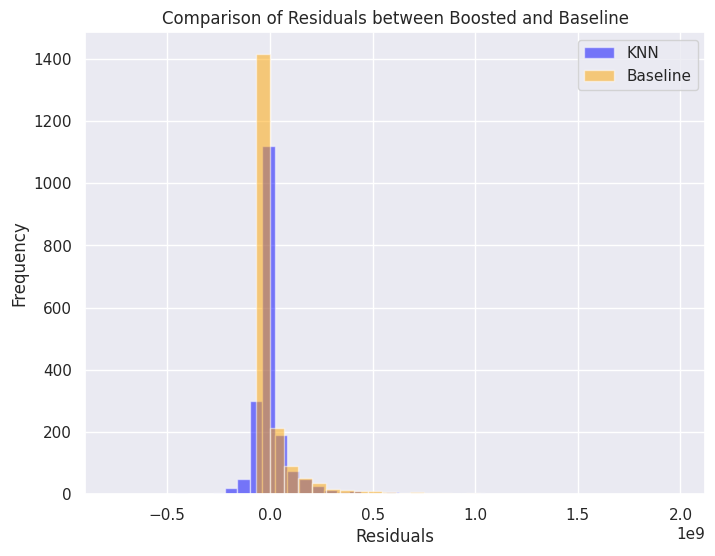

In [ ]:
## Comparing Residuals between the two models
KNN = (y_test - KNN_pred)
BaselineResiduals = (y_test - ones)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(KNN, bins=30, alpha=0.5, color='blue', label='KNN')

# Plot the residuals of the second model
ax.hist(BaselineResiduals, bins=30, alpha=0.5, color='orange', label='Baseline')

# Add labels and title
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of Residuals between KNN and Baseline')
ax.legend()

Here is another comparison between the residuals of the KNN model when compared to the baseline. The distributions are very similar to the boosted model, and only deviate slightly. Once again I think this is a very clear indication that our data in general and the predictors we are using do not have very good predictive power.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_test)

# Define the architecture of the neural network
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),  # input layer with 64 neurons and tanh activation
    Dense(32, activation='tanh'),  # hidden layer with 32 neurons and tanh activation
    Dense(1)  # output layer with 1 neuron (for regression tasks)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

predictions = model.predict(X_val_scaled)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Epoch 1/20
190/190 [==============================] - 3s 6ms/step - loss: 29136652261654528.0000 - val_loss: 34163043898228736.0000
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 29136665146556416.0000 - val_loss: 34163043898228736.0000
Epoch 3/20
190/190 [==============================] - 1s 4ms/step - loss: 29136643671719936.0000 - val_loss: 34163043898228736.0000
Epoch 4/20
190/190 [==============================] - 1s 4ms/step - loss: 29136654409138176.0000 - val_loss: 34163041750745088.0000
Epoch 5/20
190/190 [==============================] - 1s 4ms/step - loss: 29136654409138176.0000 - val_loss: 34163041750745088.0000
Epoch 6/20
190/190 [==============================] - 1s 3ms/step - loss: 29136673736491008.0000 - val_loss: 34163041750745088.0000
Epoch 7/20
190/190 [==============================] - 1s 4ms/step - loss: 29136654409138176.0000 - val_loss: 34163041750745088.0000
Epoch 8/20
190/190 [==============================] - 1s 4ms/step - loss: 29

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_test)

# Define the architecture of the neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # input layer with 64 neurons and relu activation
    Dense(32, activation='relu'),  # hidden layer with 32 neurons and relu activation
    Dense(1)  # output layer with 1 neuron (for regression tasks)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

predictions = model.predict(X_val_scaled)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Epoch 1/20
190/190 [==============================] - 1s 3ms/step - loss: 29136658704105472.0000 - val_loss: 34163024570875904.0000
Epoch 2/20
190/190 [==============================] - 0s 2ms/step - loss: 29136577099726848.0000 - val_loss: 34162805527543808.0000
Epoch 3/20
190/190 [==============================] - 0s 2ms/step - loss: 29136196995121152.0000 - val_loss: 34162148397547520.0000
Epoch 4/20
190/190 [==============================] - 0s 2ms/step - loss: 29135365918949376.0000 - val_loss: 34160892119613440.0000
Epoch 5/20
190/190 [==============================] - 0s 2ms/step - loss: 29133937842323456.0000 - val_loss: 34158903549755392.0000
Epoch 6/20
190/190 [==============================] - 0s 2ms/step - loss: 29131822570930176.0000 - val_loss: 34156141885784064.0000
Epoch 7/20
190/190 [==============================] - 0s 2ms/step - loss: 29128910583103488.0000 - val_loss: 34152338692243456.0000
Epoch 8/20
190/190 [==============================] - 0s 2ms/step - loss: 29

Lastly, I attempted to use some neural networks to see what the MSE would be like. I attempted to use both the tanh and relu activation, but due to the time it would take to fully tune these neural networks on all the different parameters, we decided not to pursue the neural networks any further. Presumably, the reson the MSE are so poor for both models is because of a lack of proper tuning, as they are worse than predicting the mean as a baseline.